Train accuracy: 0.9437833333333333
Test accuracy: 0.9304


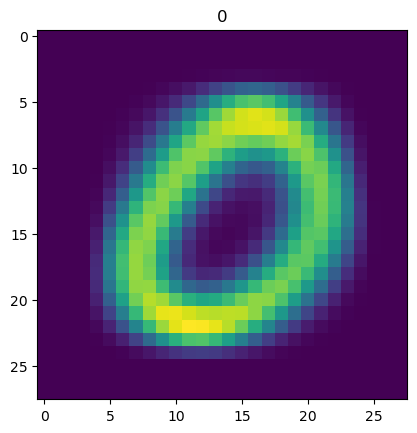

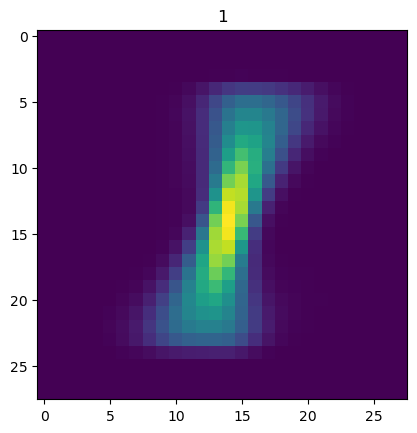

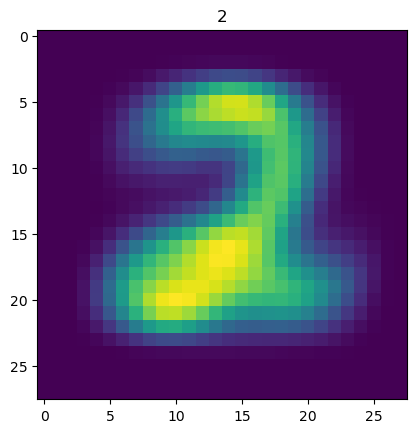

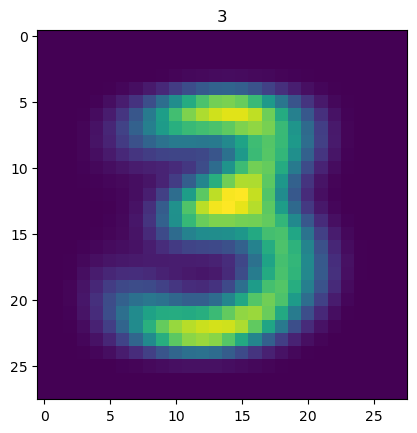

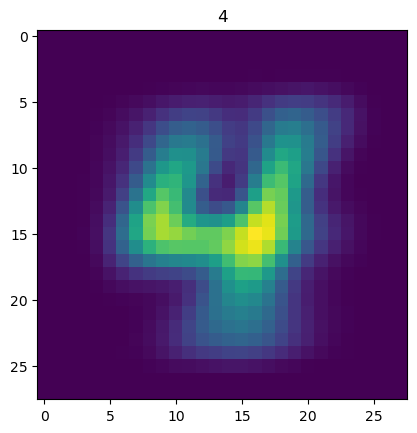

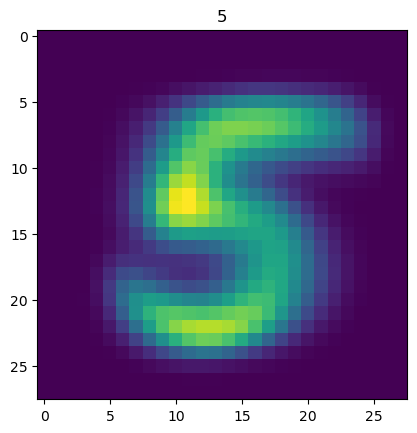

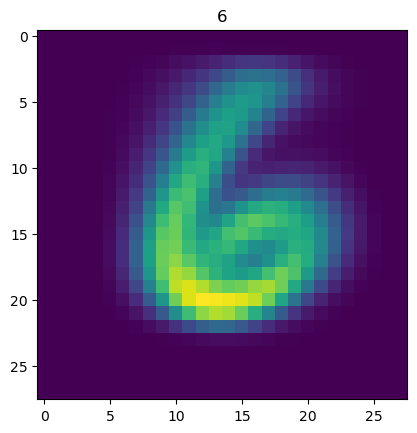

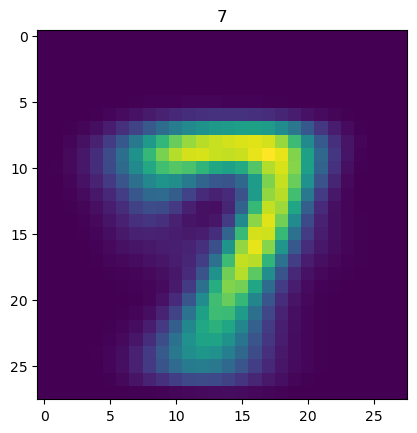

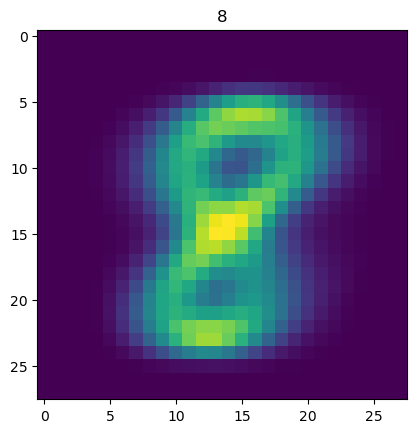

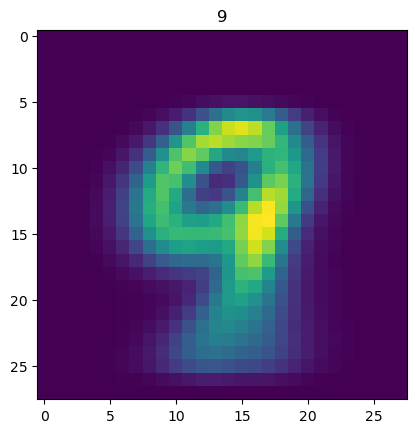

In [1]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from keras.datasets import mnist

class Bayes(object):
    def fit(self, X, Y, smoothing=1e-2): # X is data matrix, Y is label vector.
        N, D = X.shape # N number of rows (no. of examples) and D is data/feature dimension (784).
        self.gaussians = dict() # dict() is a dynamic structure in Python.
        self.priors = dict()
        labels = set(Y) # set(.) takes unique values in class label vector Y. You can also use np.unique.
        for c in labels: # loop for each class (from 0 to 9).
            current_x = X[Y == c] # Collect from total X, all those examples (rows) which have label c.
            self.gaussians[c] = {
                'mean': current_x.mean(axis=0), # find column wise (axis=0) mean. Mean vector will be [1x784] having mean of each column (feature).
                'cov': np.cov(current_x.T) + np.eye(D) * smoothing, # find covariance matrix. Covariance matric will be [784x784].
            }
            self.priors[c] = float(len(Y[Y == c])) / len(Y) # Priors are simple class probabilities P(C) and are equal to (# of examples of class c / total # of examples). example and total count can be found in label vector Y.

    def score(self, X, Y): # A function to calculate accuracy.
        P = self.predict(X) # First calling predict function which is defined later.
        return np.mean(P == Y) # Calculating mean of prediction (P) for each class in Y.

    def predict(self, X): # Main classifier predictor function.
        N, D = X.shape  # N number of rows (no. of examples) and D is data/feature dimension (784).
        K = len(self.gaussians)
        log_P = np.zeros((N, K)) # Initializing posterior P(C|x) matrix.
        for c, g in self.gaussians.items(): # c iterated fromn [0 - 9] for each class.
            mean, cov = g['mean'], g['cov']
            cov += np.eye(D) * 1e-6  # Adding a small number to ensure all elements are non-zero.
            cov_inv = np.linalg.inv(cov) # linear algebra function for finding inverse of covariance matrix.
            det_cov = np.linalg.det(cov) # linear algebra function to find determinant of matrix.
            log_prior = np.log(self.priors[c]) # Taking log of class priors.
            for i in range(N): # For each example in data X (train or test).
                x = X[i]
                diff = x - mean # These few line find the log of P(x|C) uisng Gaussian/Normal distribution. Log is taken to make computation easy on processor.
                log_exponent = -0.5 * diff.dot(cov_inv).dot(diff)
                log_likelihood = log_exponent - 0.5 * D * np.log(2 * np.pi) - 0.5 * np.log(np.abs(det_cov) + 1e-6)  # Adding a small value to avoid division by zero.
                log_P[i, c] = log_likelihood + log_prior # class wise posteriors i.e., P(C|x)=P(x|C)P(C)----->log(P(C|x)=P(x|C)P(C)) = log(P(x|C))+log(P(C)).
        return np.argmax(log_P, axis=1)


# Load the MNIST dataset
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()
print(Ytrain.shape)
# Flatten the images
Xtrain = Xtrain.reshape(Xtrain.shape[0], -1)
Xtest = Xtest.reshape(Xtest.shape[0], -1)

# Normalize the pixel values to be between 0 and 1
Xtrain = Xtrain / 255.0
Xtest = Xtest / 255.0

# Create the model and fit it to the training data
model = Bayes()
model.fit(Xtrain, Ytrain)

# Compute and print the train and test accuracies
print("Train accuracy:", model.score(Xtrain, Ytrain))
print("Test accuracy:", model.score(Xtest, Ytest))

# Plot the mean of each class (optional)
for c, g in model.gaussians.items():
    plt.imshow(g['mean'].reshape(28, 28))
    plt.title(c)
    plt.show()